# 3ML with Fermi GBM TTE  and LAT LLE Data
### Purpose

This demonstrates of you can use LLE data directly in 3ML

For more detail on the Fermi TTE plugin, check out its demo.

#### Let's check it out!

Import **3ML** as always to make sure you have the plugin.

In [1]:
%matplotlib inline
%matplotlib notebook
import numpy as np
from threeML import *

get_available_plugins()

Configuration read from /Users/jburgess/.threeML/threeML_config.yml
Available plugins:

FermiGBMTTELike for Fermi GBM TTE (all detectors)
FermiLATLLELike for Fermi LAT LLE
OGIPLike for All OGIP-compliant instruments
XYLike for n.a.
EventListLike for Generic EventList data
SwiftXRTLike for Swift XRT


## Obtaining data

Use the LLE and GBM data downloaders to get the data:

In [2]:
# os.path.join is a way to generate system-independent
# paths (good for unix, windows, Mac...)
trigger_number = 'bn080916009'

data_dir_gbm = os.path.join('gbm',trigger_number)
gbm_data = download_GBM_trigger_data(trigger_number,detectors=['n3','n4','b0'],destination_directory=data_dir_gbm,compress_tte=True)


data_dir_lle = os.path.join('lat')

lle_data = download_LLE_trigger_data(trigger_number,destination_directory=data_dir_lle)

src_selection = "0.-71."

### Plugin building

Build our plugins from our data. The LLE plugin is an EventList like the GBM TTE plugin and operates in a similar way. 

Simply select a source interval, background interval(s), etc. (all of which can be changed later) and the plugin will prepare the data for you.

As with the TTE plugin (and any OGIPLike plugin), the data can be saved out to PHA files for cross-checking with XSPEC.

In [3]:
lle = FermiLATLLELike("LLE",
                      os.path.join(data_dir_lle, "gll_lle_bn080916009_v10.fit"),
                      os.path.join(data_dir_lle, "gll_pt_bn080916009_v10.fit"),
                      os.path.join(data_dir_lle, "gll_cspec_bn080916009_v10.rsp"),
                      src_selection,
                       "-100-0,100-200")



nai3 = FermiGBMTTELike('NAI3',
                       os.path.join(data_dir_gbm, "glg_tte_n3_bn080916009_v01.fit.gz"),
                       os.path.join(data_dir_gbm, "glg_cspec_n3_bn080916009_v00.rsp2"),
                       src_selection,
                        "-10-0,120-200",
                       poly_order=2)

nai4 = FermiGBMTTELike('NAI4',
                       os.path.join(data_dir_gbm, "glg_tte_n4_bn080916009_v01.fit.gz"),
                       os.path.join(data_dir_gbm, "glg_cspec_n4_bn080916009_v00.rsp2"),
                       src_selection,
                       "-10-0,120-200",
                       poly_order=-1,
                      verbose=False)

bgo0 = FermiGBMTTELike('BGO0',
                       os.path.join(data_dir_gbm, "glg_tte_b0_bn080916009_v01.fit.gz"),
                       os.path.join(data_dir_gbm, "glg_cspec_b0_bn080916009_v00.rsp2"),
                        src_selection,
                       "-10-0,120-200")



Auto-determined polynomial order: 1




Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Binned 1-order polynomial fit with the Powell method


Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum EBOUNDS energy


WARNING UserWarning: No TLMIN keyword found. This DRM does not follow OGIP standards. Assuming TLMIN=1


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Unbinned 2-order polynomial fit with the Nelder-Mead method


Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"

WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum 

Auto-determined polynomial order: 1




Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Unbinned 1-order polynomial fit with the Nelder-Mead method


Auto-probed noise models:
- observation: poisson
- background: gaussian


#### What's in the plugin?

The LLE peak function (a common funciton to all EventLists), reveals lots of information about the current selections.

In [4]:
lle

n. channels                                             50
total rate                                         27.7296
total bkg. rate                                    6.00637
total bkg. rate error                             0.187211
exposure                                           65.6699
bkg. exposure                                      65.6699
significance                                       42.9053
is poisson                                            True
bkg. is poisson                                      False
response                 lat/gll_cspec_bn080916009_v10.rsp
active selection (1)            time interval 0.0 - 71.0 (duration: 71.0)
active deadtime                                                    5.3301
polynomial selection (1)     time interval -100.0 - 0.0 (duration: 100.0)
polynomial selection (2)    time interval 100.0 - 200.0 (duration: 100.0)
polynomial order                                                        1
polynomial fit type                     

Let's look at the lightcurve of LLE file to check out background fit:

<IPython.core.display.Javascript object>


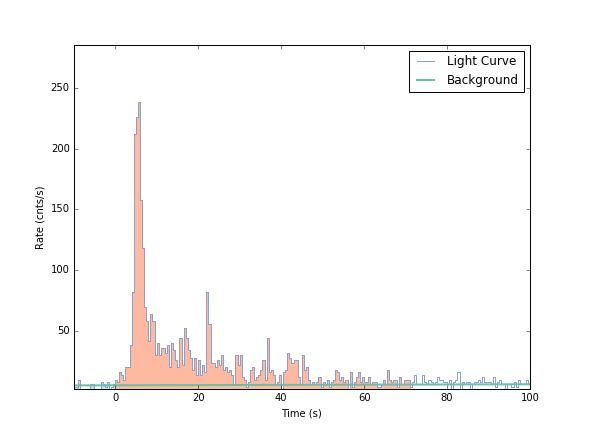

In [7]:
lle.view_lightcurve(-10,100,dt=.5)

And an NaI:

<IPython.core.display.Javascript object>


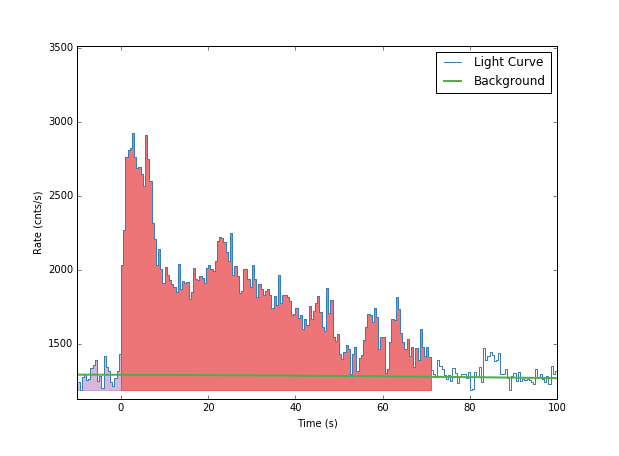

In [8]:
nai3.view_lightcurve(-10,100.,.5)

### Energy selection

Like any OGIPLike, we need to select the energies we would like to fit. LLE data below 50 MeV has a lot of dispersion and should not be selected as indicated by the BAD (red) region.

Range 50000-100000 translates to channels 11-16
Now using 6 channels out of 50


<IPython.core.display.Javascript object>


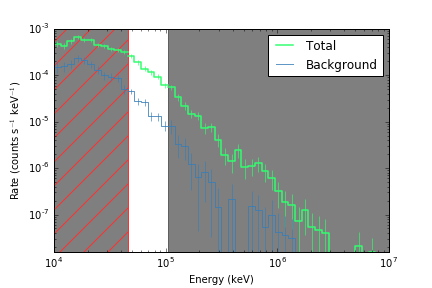

Range 10.0-30.0 translates to channels 6-21
Range 40.0-900.0 translates to channels 27-124
Now using 114 channels out of 128
Range 250-43000 translates to channels 1-126
Now using 126 channels out of 128


In [9]:

lle.set_active_measurements("50000-100000")
lle.view_count_spectrum()


nai3.set_active_measurements("10.0-30.0", "40.0-900.0")
nai4.set_active_measurements("10.0-30.0", "40.0-900.0")
bgo0.set_active_measurements("250-43000")


## Fitting!

We are now ready for the standard **3ML** process. We perform and MLE fit here, but Bayesian fitting is also possible.


In [10]:

ra = 121.8
dec = -61.3

data_list = DataList(nai3,nai4,bgo0,lle )

band= Band()

GRB = PointSource( trigger_number, ra, dec, spectral_shape=band )

model = Model( GRB )


In [11]:
jl = JointLikelihood( model, data_list, verbose=False )

res = jl.fit()

Best fit values:



,Best fit value,Unit
bn080916009.spectrum.main.Band.K,0.0148 +/- 0.0007,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-1.06 +/- 0.04,
bn080916009.spectrum.main.Band.beta,-2.173 +/- 0.024,
bn080916009.spectrum.main.Band.xp,(5.1 +/- 0.7)e+02,keV



NOTE: errors on parameters are approximate. Use get_errors().


Correlation matrix:



1.00,0.91,-0.96,0.75
0.91,1.00,-0.88,0.66
-0.96,-0.88,1.00,-0.84
0.75,0.66,-0.84,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
total,3354.297465
NAI3,1078.019126
NAI4,1040.378703
BGO0,1206.287686
LLE,29.611950


## Examining our fit

<IPython.core.display.Javascript object>


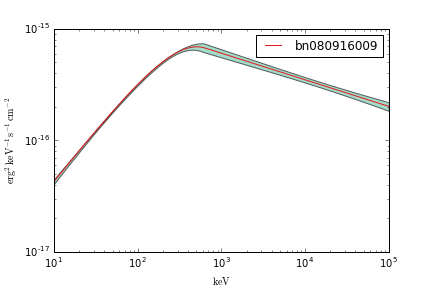

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [12]:
sp = SpectralPlotter(jl)

_=sp.plot_model(y_unit='erg2/(cm2 s keV)', num_ene=200,x_max=1E5)

We can examine our fit with the data:

<IPython.core.display.Javascript object>


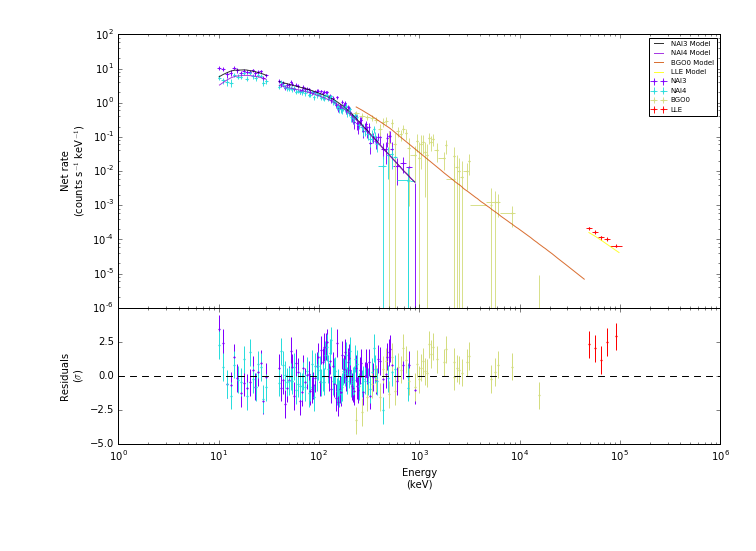

In [13]:
_ = display_ogip_model_counts(jl,min_rate=1,step=False)

In [14]:
res = jl.get_errors()

Name,Value,Unit
bn080916009.spectrum.main.Band.K,0.0148 -0.0007 +0.0008,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-1.06 -0.04 +0.04,
bn080916009.spectrum.main.Band.xp,(5.1 -0.6 +0.8)e+02,keV
bn080916009.spectrum.main.Band.beta,-2.173 -0.025 +0.022,


<IPython.core.display.Javascript object>


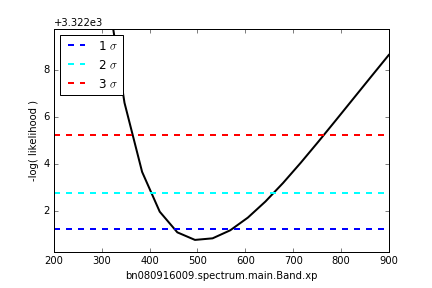

In [13]:
res = jl.get_contours(band.xp,200,900,20)

<IPython.core.display.Javascript object>


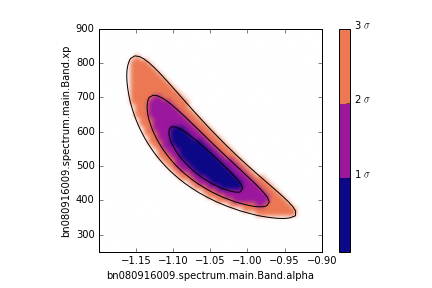

In [14]:
res = jl.get_contours(band.xp,250,900,50,band.alpha,-1.2,-0.9,50)